# Topic modeling - TRAIN

## Vectorización semántica y agrupamiento temático

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# Cargar el archivo CSV
ruta = r'' # Ruta donde se encuentra tu archivo CSV con las descripciones 
df = pd.read_csv(ruta, sep=';')

# Filtrar las filas donde 'Nombre Carpeta' contiene '/train/'
df_train = df[df['Nombre Carpeta'].str.contains(r'/train', na=False, regex=True)]

# Extraer la columna de descripciones
descriptions = df_train['Descripciones imagenes'].tolist()

# Cargar el modelo de Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generar los embeddings de las descripciones
embeddings = model.encode(descriptions, show_progress_bar=True)

# Convertir los embeddings en una matriz de NumPy
embeddings_np = np.array(embeddings)

# Crear el modelo BERTopic
topic_model = BERTopic()

# Ajustar el modelo sobre los embeddings generados
topics, probs = topic_model.fit_transform(descriptions, embeddings_np)

topic_model.save("bertopic_train_model")

# Mostrar los tópicos generados
topic_info = topic_model.get_topic_info()
print('Tópicos obtenidos: ', topic_info)

# Ver las palabras clave de un tópico específico
print(f'Palabras claves del tópico: ', topic_model.get_topic(0))

# Visualización interactiva
topic_model.visualize_topics()

c:\Users\mpellicer\Documents\TFM\TFM_separado\TFM_Marc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 56/56 [00:14<00:00,  3.90it/s]
2025-07-03 12:00:05,461 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Tópicos obtenidos:      Topic  Count                                   Name  \
0      -1     27       -1_pushpins_box_the_compartments   
1       0    360                0_bag_bolts_washers_two   
2       1    343          1_wire_connectors_mesh_levers   
3       2    173              2_tray_granola_and_banana   
4       3    137     3_pins_push_container_compartments   
5       4    133         4_container_granola_and_banana   
6       5    112              5_bottle_liquid_label_the   
7       6    112            6_bottle_juice_label_liquid   
8       7    111              7_bottle_liquid_label_the   
9       8     77  8_pushpins_container_compartments_the   
10      9     49     9_organizer_pins_compartments_push   
11     10     39      10_tangerines_tray_granola_banana   
12     11     32          11_box_pins_push_compartments   
13     12     20       12_box_pins_storage_compartments   
14     13     19         13_case_pins_compartments_push   
15     14     17          14_termina

## Comparación semántica

In [2]:
# Crear un diccionario para almacenar los embeddings por tópico
topic_embeddings = {}
topic_centroids = {}

# Agrupar embeddings por tópico y calcular el centroide (media)
for topic_id in np.unique(topics):
    embeddings_in_topic = [embeddings_np[i] for i in range(len(embeddings_np)) if topics[i] == topic_id]
    embeddings_in_topic = np.array(embeddings_in_topic)

    topic_embeddings[topic_id] = embeddings_in_topic

    # Calcular el centroide como la media
    if len(embeddings_in_topic) > 0:
        centroid = np.mean(embeddings_in_topic, axis=0)
        topic_centroids[topic_id] = centroid
    else:
        print(f"Tópico {topic_id} no tiene embeddings.")

# Convertir el diccionario a un array para guardar (opcional)
topic_ids = list(topic_centroids.keys())
centroid_matrix = np.array([topic_centroids[tid] for tid in topic_ids])

# Guardar los centroides para usar más adelante
np.save('topic_centroids.npy', centroid_matrix)
np.save('topic_ids.npy', np.array(topic_ids))

print(f"Se han generado {len(topic_centroids)} centroides de tópicos.")


Se han generado 17 centroides de tópicos.


# Topic modeling - TEST

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

# Cargar el archivo CSV
ruta = r'' # Ruta donde se encuentra tu archivo CSV con las descripciones 
df = pd.read_csv(ruta, sep=';')

# Filtrar las filas donde 'Nombre Carpeta' contiene '/test/'
df_test = df[df['Nombre Carpeta'].str.contains(r'/test', na=False, regex=True)].copy()

# Extraer la columna de descripciones
descriptions_test = df_test['Descripciones imagenes'].tolist()

# Cargar el modelo de Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generar los embeddings de las descripciones
embeddings_test = model.encode(descriptions_test, show_progress_bar=True)
np.save('embeddings_test.npy', embeddings_test)




# Extraer la clase desde la ruta del nombre de carpeta
df_test['Clase Anomalia'] = df_test['Nombre Carpeta'].apply(lambda x: x.split('/')[-1].strip().lower())

df_test['Es_anómalo'] = df_test['Clase Anomalia'] != 'good'




# Cargar el modelo BERTopic entrenado solo con imágenes 'good'
topic_model = BERTopic.load("bertopic_train_model")
topics, probs = topic_model.transform(descriptions_test, embeddings_test)

# Asignar al DataFrame
df_test['Tópico'] = topics
df_test['Probabilidad'] = probs

# Tópico más frecuente en test
top_topic_train = pd.Series(topics).value_counts().idxmax()
df_test['Es_tópico_good'] = df_test['Tópico'] == top_topic_train




# Evaluación 1: Por cambio de tópico
y_true = df_test['Es_anómalo']
y_pred = ~df_test['Es_tópico_good']

print("=== Evaluación por cambio de tópico ===")
print(classification_report(y_true, y_pred, target_names=['Good', 'Anomalía']))




# Evaluación 2: Por baja probabilidad del modelo
umbral_prob = 0.3
df_test['Pred_anómalo_por_confianza'] = df_test['Probabilidad'] < umbral_prob
y_pred_conf = df_test['Pred_anómalo_por_confianza']

print(f"\n=== Evaluación por baja probabilidad (umbral = {umbral_prob}) ===")
print(classification_report(y_true, y_pred_conf, target_names=['Good', 'Anomalía']))




# Evaluación 3: Por similitud con centroides del train

# Cargar centroides generados con train
centroids = np.load('topic_centroids.npy')
topic_ids = np.load('topic_ids.npy')

# Calcular similitud coseno con cada centroide
similarity_matrix = cosine_similarity(embeddings_test, centroids)

# Obtener el índice del centroide más similar
most_similar_topic_indices = np.argmax(similarity_matrix, axis=1)
assigned_topic_ids = topic_ids[most_similar_topic_indices]
similarities = np.max(similarity_matrix, axis=1)

df_test['Tópico más cercano (por centroide)'] = assigned_topic_ids
df_test['Similitud con centroide'] = similarities

# Umbral de similitud para detección de anomalía
umbral_similitud = 0.7
df_test['Pred_anómalo_por_similitud'] = df_test['Similitud con centroide'] < umbral_similitud

print(f"\n=== Evaluación por similitud con centroide (umbral = {umbral_similitud}) ===")
print(classification_report(df_test['Es_anómalo'], df_test['Pred_anómalo_por_similitud'], target_names=['Good', 'Anomalía']))




# Mostrar los tópicos generados
topic_info = topic_model.get_topic_info()
print('\nTópicos obtenidos:')
print(topic_info)

# Palabras clave del tópico más común
print('\nPalabras clave del tópico más común:')
print(topic_model.get_topic(top_topic_train))

# Visualización
topic_model.visualize_topics()


Batches: 100%|██████████| 48/48 [00:09<00:00,  5.25it/s]


=== Evaluación por cambio de tópico ===
              precision    recall  f1-score   support

        Good       0.36      0.21      0.26       563
    Anomalía       0.63      0.78      0.70       967

    accuracy                           0.57      1530
   macro avg       0.49      0.49      0.48      1530
weighted avg       0.53      0.57      0.54      1530


=== Evaluación por baja probabilidad (umbral = 0.3) ===
              precision    recall  f1-score   support

        Good       0.36      0.88      0.51       563
    Anomalía       0.56      0.09      0.15       967

    accuracy                           0.38      1530
   macro avg       0.46      0.49      0.33      1530
weighted avg       0.49      0.38      0.28      1530


=== Evaluación por similitud con centroide (umbral = 0.7) ===
              precision    recall  f1-score   support

        Good       0.38      0.73      0.50       563
    Anomalía       0.67      0.31      0.42       967

    accuracy          

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE

# t-SNE para reducir a 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
embeddings_2d = tsne.fit_transform(embeddings_test)

# Añadir al DataFrame
df_test['TSNE-1'] = embeddings_2d[:, 0]
df_test['TSNE-2'] = embeddings_2d[:, 1]



# Visualización 1: Coloreado por clase real
fig1 = px.scatter(
    df_test, x='TSNE-1', y='TSNE-2',
    color='Clase Anomalia',
    labels={'Clase Anomalia': 'Tipo de imagen'},
    hover_data=['Nombre Carpeta', 'Tópico', 'Similitud con centroide'],
    title='Distribución t-SNE real por clase',
    width=900, height=600
)
fig1.show()



# Visualización 2: Coloreado por predicción de anomalía (similitud)
fig2 = px.scatter(
    df_test, x='TSNE-1', y='TSNE-2',
    color='Pred_anómalo_por_similitud',
    labels={'Pred_anómalo_por_similitud' : 'Anomalía predicha'},
    color_discrete_map={True: 'red', False: 'green'},
    hover_data=['Nombre Carpeta', 'Clase Anomalia', 'Similitud con centroide'],
    title='Predicción de anomalía por similitud con centroides',
    width=900, height=600
)
fig2.show()


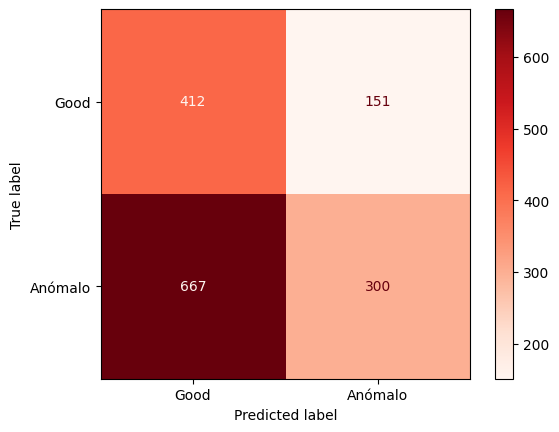

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Etiquetas verdaderas (0 = good, 1 = anomalía)
y_true = df_test['Es_anómalo'].astype(int)

# Etiquetas predichas por similitud (puedes cambiar por otro método si quieres)
y_pred_sim = df_test['Pred_anómalo_por_similitud'].astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_sim)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Anómalo'])
disp.plot(cmap='Blues')